In [2]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model
import seaborn as sns

import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="seaborn", message="^internal gelsd")

In [3]:
data_path = ("NYC_Crime_2013.xls"
            )

crime_data = pd.read_excel(data_path, header=4, skip_footer=3)

crime_data.describe()

/usr/local/lib/python3.6/site-packages/pandas/util/_decorators.py:177: FutureWarning: the 'skip_footer' keyword is deprecated, use 'skipfooter' instead
  return func(*args, **kwargs)


,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
count,3.480000e+02,348.000000,348.000000,0.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,187.000000
mean,4.003763e+04,201.594828,1.566092,NaN,5.864943,72.902299,121.261494,792.606322,119.683908,637.017241,35.905172,1.871658
std,4.500374e+05,2815.268504,18.303673,NaN,60.425452,1031.032873,1706.131730,7659.724746,924.948789,6346.054451,403.423826,10.693411
min,5.260000e+02,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.003000e+03,2.000000,0.000000,NaN,0.000000,0.000000,1.000000,40.500000,6.000000,31.000000,0.000000,0.000000
50%,7.233500e+03,6.000000,0.000000,NaN,0.000000,1.000000,4.000000,112.500000,17.500000,94.000000,2.000000,0.000000
75%,1.842750e+04,22.000000,0.000000,NaN,2.000000,5.000000,14.000000,341.000000,51.250000,287.250000,7.000000,1.000000
max,8.396126e+06,52384.000000,335.000000,NaN,1112.000000,19170.000000,31767.000000,141971.000000,16606.000000,117931.000000,7434.000000,132.000000


In [4]:
crime_data.columns = [
            'city', 'population', 'murder', 
            'violent_crime', 'rape1', 
            'rape2', 'robbery', 'aggravated_assault',
            'property_crime', 'burglary', 'larceny', 'auto_theft', 'arson'
        ]

# set raw to df
df = crime_data


In [5]:
df.head()


,city,population,murder,violent_crime,rape1,rape2,robbery,aggravated_assault,property_crime,burglary,larceny,auto_theft,arson
0,Adams Village,1861,0,0,NaN,0,0,0,12,2,10,0,0.0
1,Addison Town and Village,2577,3,0,NaN,0,0,3,24,3,20,1,0.0
2,Akron Village,2846,3,0,NaN,0,0,3,16,1,15,0,0.0
3,Albany,97956,791,8,NaN,30,227,526,4090,705,3243,142,NaN
4,Albion Village,6388,23,0,NaN,3,4,16,223,53,165,5,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 13 columns):
city                  348 non-null object
population            348 non-null int64
murder                348 non-null int64
violent_crime         348 non-null int64
rape1                 0 non-null float64
rape2                 348 non-null int64
robbery               348 non-null int64
aggravated_assault    348 non-null int64
property_crime        348 non-null int64
burglary              348 non-null int64
larceny               348 non-null int64
auto_theft            348 non-null int64
arson                 187 non-null float64
dtypes: float64(2), int64(10), object(1)
memory usage: 35.4+ KB


In [7]:
# Drop rape1 column since all nulls
df.drop(labels='rape1', axis=1, inplace=True)

In [8]:
# replace null values with 0
df.fillna(value=0, axis=0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 12 columns):
city                  348 non-null object
population            348 non-null int64
murder                348 non-null int64
violent_crime         348 non-null int64
rape2                 348 non-null int64
robbery               348 non-null int64
aggravated_assault    348 non-null int64
property_crime        348 non-null int64
burglary              348 non-null int64
larceny               348 non-null int64
auto_theft            348 non-null int64
arson                 348 non-null float64
dtypes: float64(1), int64(10), object(1)
memory usage: 32.7+ KB


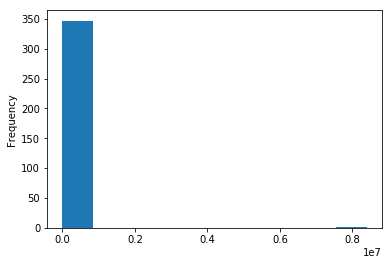

In [9]:
df.population.plot.hist()
plt.show()

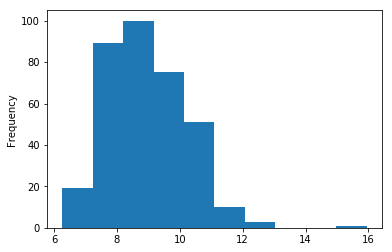

In [10]:
np.log(df.population).plot.hist()
plt.show()

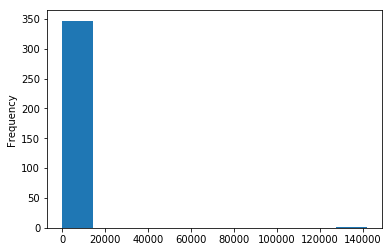

In [11]:
df.property_crime.plot.hist()
plt.show()

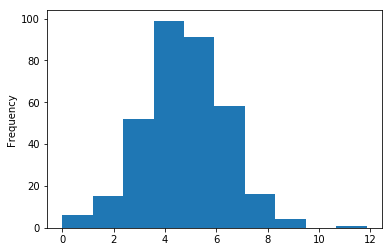

In [12]:
np.log(df.property_crime[df.property_crime != 0]).plot.hist()
plt.show()

In [13]:
features = pd.DataFrame([df.property_crime, df.population, df.population**2, df.murder, df.robbery]).T

features.columns = ['property_crime', 'population', 'population2', 'murder', 'robbery']
features.head()

,property_crime,population,population2,murder,robbery
0,12,1861,3463321,0,0
1,24,2577,6640929,3,0
2,16,2846,8099716,3,0
3,4090,97956,9595377936,791,227
4,223,6388,40806544,23,4


In [14]:
# Encode Variables 
def zero(x):
    result = 0
    if x > 0:
        result = 1
    return result

features['murder'] = features.murder.apply(zero)
features['robbery'] = features.robbery.apply(zero)

features.head()

,property_crime,population,population2,murder,robbery
0,12,1861,3463321,0,0
1,24,2577,6640929,1,0
2,16,2846,8099716,1,0
3,4090,97956,9595377936,1,1
4,223,6388,40806544,1,1


In [15]:
y = features.property_crime.values.reshape(-1, 1)
X = features.iloc[:,1:]

# Instantiate our model.
lr = linear_model.LinearRegression()

# Fit our model to our data.
lr.fit(X, y)

# Inspect the results.
print('\nCoefficients: \n', lr.coef_)
print('\nIntercept: \n', lr.intercept_)
print('\nR-squared:')
print(lr.score(X, y))


Coefficients: 
 [[ 3.47652086e-02 -2.12376257e-09 -4.74211735e+01 -7.75916489e+01]]

Intercept: 
 [-79.93746352]

R-squared:
0.9961279337434973


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [16]:
# add 1 to property crime
features['property_crime'] = features.property_crime + 1


In [17]:
features['property_crime'] = np.log(features.property_crime)


In [18]:
y = features.property_crime.values.reshape(-1, 1)
X = features.iloc[:,1:]

# Instantiate our model.
lr = linear_model.LinearRegression()

# Fit our model to our data.
lr.fit(X, y)

# Inspect the results.
print('\nCoefficients: \n', lr.coef_)
print('\nIntercept: \n', lr.intercept_)
print('\nR-squared:')
print(lr.score(X, y))


Coefficients: 
 [[ 2.78592629e-05 -3.22057825e-12  1.29691839e+00  1.30473096e+00]]

Intercept: 
 [2.38221213]

R-squared:
0.7262270637962646


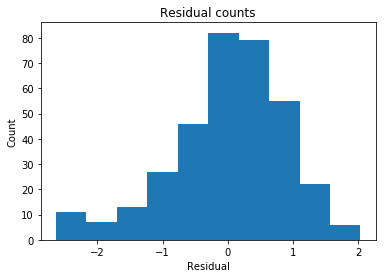

In [19]:
# Extract predicted values.
predicted = lr.predict(X).ravel()
actual = features.property_crime

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

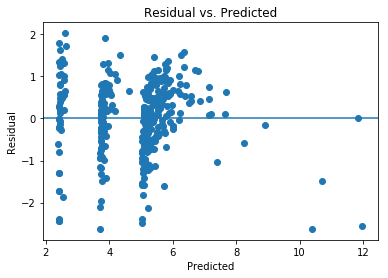

In [20]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()


In [21]:
correlation_matrix = X.corr()
display(correlation_matrix)

,population,population2,murder,robbery
population,1.000000,0.998264,0.034255,0.064371
population2,0.998264,1.000000,0.022352,0.043983
murder,0.034255,0.022352,1.000000,0.508127
robbery,0.064371,0.043983,0.508127,1.000000
